<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install git+https://github.com/pvigier/perlin-numpy

  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-57ierh9v
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-57ierh9v
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Preparing metadata (setup.py) ... done
  Created wheel for perlin-numpy: filename=perlin_numpy-0.0.0-py3-none-any.whl size=4723 sha256=7b0bd36970270b3f190f8ad7c6204b1858574abd5859981088139d8389054ab1
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kcler_4/wheels/d0/67/1b/569e9d602b147a53e4ab67a3592944572d7d3886dc3a2e095e
Successfully built perlin-numpy


In [2]:
pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56263 sha256=0452ed87cd646b80475d293fc473a3491777c45fc153756f9b11d47d0d200ef2
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


In [3]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 3.6 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
import numpy as np
from perlin_numpy import generate_perlin_noise_2d
import noise
from noise import pnoise2
from noise import snoise3
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


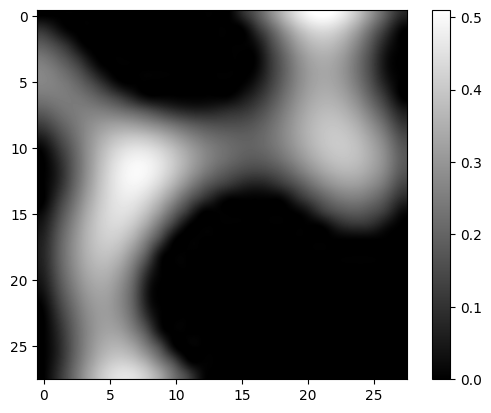

In [5]:
#np.random.seed(1)
noise = generate_perlin_noise_2d((28, 28), (2, 2))
noise = np.clip(noise,0,1)
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()

In [6]:


# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
#x_train = (x_train.astype("float32") - 127.5) / 127.5
#y_train = y_train.reshape(-1, 1)
x_train = (x_train.astype("float32")) / np.max(x_train)


# Example usage
image_index = 0  # Index of the image you want to retrieve
image = x_train[image_index]
print(image.shape)
print(x_train.shape[0])


11490434/11490434 [==============================] - 0s 0us/step
(28, 28)
60000


In [7]:
print(np.max(x_train))

1.0


In [8]:
x_train2 = x_train[:100]
y_train2 = y_train[:100]

In [9]:
class AddNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, stddev, probability, **kwargs):
        super(AddNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev
        self.probability = probability

    def call(self, inputs, training=None):
        if training:

            if tf.random.uniform(()) < self.probability:
                perlin = generate_perlin_noise_2d((28, 28), (2, 2))
                perlin = tf.convert_to_tensor(perlin, dtype=tf.float32)
                perlin = tf.clip_by_value(perlin, 0, 1)
                perlin = tf.reshape(perlin, (28, 28, 1))
                noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
                output = inputs + noise * perlin
                return tf.clip_by_value(output, 0, 1)
            else:
                return inputs
        return inputs

In [10]:
class AddNoiseLayertest(tf.keras.layers.Layer):
    def __init__(self, stddev=.5, **kwargs):
        super(AddNoiseLayertest, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:

              perlin = generate_perlin_noise_2d((28, 28), (2, 2))
              perlin = tf.convert_to_tensor(perlin, dtype=tf.float32)
              perlin = tf.clip_by_value(perlin, 0, 1)
              perlin = tf.reshape(perlin, (28, 28, 1))
              noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
              output = inputs + noise * perlin
              return tf.clip_by_value(output, 0, 1)
        return inputs

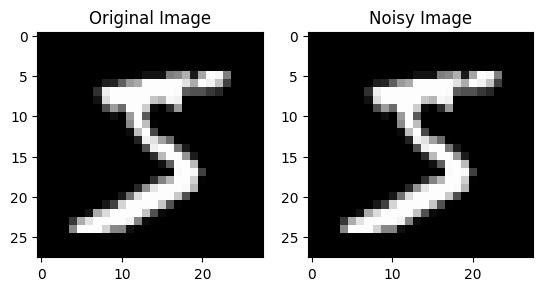

(28, 28, 1)


In [11]:
# Create a random 28x28 image tensor
image = x_train[0]
image = np.expand_dims(image,-1)
# Instantiate the RandomNoiseLayer
GaussianPerlinNoiseLayer = AddNoiseLayer(.5,.5)

# Pass the image through the layer
noisy_image = GaussianPerlinNoiseLayer(image,training=True)

# Display the original and noisy images
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')  # Display the original image
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(noisy_image), cmap='gray')  # Display the noisy image
plt.title('Noisy Image')
plt.show()

print(noisy_image.shape)

In [12]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.activation = tf.keras.activations.get(activation)

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')
        self.shortcut_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        shortcut = self.shortcut(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        x = tf.keras.layers.add([x, shortcut])
        x = self.activation(x)

        return x

In [13]:
class CustomFullAug(tf.keras.layers.Layer):
    def __init__(self, probability=.2,rot_factor=.2,height=.2,width=.2,stdev=.2):
        super(CustomFullAug, self).__init__()
        self.probability = probability

        self.rot_factor = rot_factor
        self.height = height
        self.width = width
        self.stdev = stdev
        self.flip_layer = tf.keras.layers.RandomFlip()
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=rot_factor)
        self.noise_layer = AddNoiseLayertest()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            #flipped_data = self.flip_layer(inputs, training=training)
            rotated_data = self.rotation_layer(inputs, training=training)
            zoomed_data = self.zoom_layer(rotated_data, training=training)
            noised = self.noise_layer(zoomed_data, training=training)
            return noised
        else:
            return inputs

In [14]:

class CustomFlipLayer(tf.keras.layers.Layer):
    def __init__(self, probability):
        super(CustomFlipLayer, self).__init__()
        self.probability = probability
        self.flip_layer = tf.keras.layers.RandomFlip()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            flipped_data = self.flip_layer(inputs, training=training)
            return flipped_data
        else:
            return inputs

In [15]:
class CustomRotationLayer(tf.keras.layers.Layer):
    def __init__(self, probability, factor):
        super(CustomRotationLayer, self).__init__()
        self.probability = probability
        self.factor = factor
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=factor)

    def call(self, inputs, training=True):
        if tf.random.uniform(()) < self.probability:
            rotated_data = self.rotation_layer(inputs, training=training)
            return rotated_data
        else:
            return inputs

In [16]:
class CustomZoomLayer(tf.keras.layers.Layer):
    def __init__(self, probability,height, width):
        super(CustomZoomLayer, self).__init__()
        self.probability = probability
        self.height = height
        self.width = width
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)

    def call(self, inputs, training=False):
        if tf.random.uniform(()) < self.probability:
            zoomed_data = self.zoom_layer(inputs, training=training)
            return zoomed_data
        else:
            return inputs

In [39]:


def build_generator():
    noise_shape = (28,28,1)
    noise = layers.Input(shape=noise_shape)
    input_digit = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 28*28)(input_digit)
    digit_embedding = layers.Reshape((28, 28, 1))(digit_embedding)


    x = layers.Concatenate()([noise, digit_embedding])


    x = layers.Conv2D(128, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 2, strides=1, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 2, strides=1, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(1, 2, strides=2, padding="same", activation="sigmoid")(x)



    model = tf.keras.models.Model(inputs=[noise, input_digit], outputs=x)
    return model

generator = build_generator()
generator.summary()



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 784)       7840        ['input_16[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape_5 (Reshape)            (None, 28, 28, 1)    0           ['embedding_5[0][0]']            
                                                                                            

In [48]:

def build_discriminator():
    input_image = layers.Input(shape=(28, 28, 1))
    digit_input = layers.Input(shape=(1,), dtype="int32")
    digit_embedding_2d = layers.Embedding(10, 28*28)(digit_input)
    digit_embedding_2d = layers.Reshape((28, 28, 1))(digit_embedding_2d)

    #noise = AddNoiseLayer(stddev=0.2,probability=.1)(input_image)  # Pass the input image through the PerlinNoiseLayer
    aug = CustomFullAug(probability=.2)(input_image)
    merged_input = layers.Concatenate()([aug, digit_embedding_2d])

    x = layers.Conv2D(64,4,strides=(1,1),padding='same',activation='gelu')(merged_input)
    x = layers.Dropout(.8)(x)
    x = layers.Conv2D(64,4,strides=(2,2),padding='same',activation='gelu')(x)
    x = layers.Dropout(.8)(x)
    x = layers.Conv2D(64,3,strides=(2,2),padding='same',activation='gelu')(x)
    x = layers.Dropout(.8)(x)
    x = layers.Conv2D(64,2,strides=(2,2),padding='same',activation='tanh')(x)
    x = layers.Dropout(.8)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=[input_image, digit_input], outputs=x)
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 784)       7840        ['input_22[0][0]']               
                                                                                                  
 custom_full_aug_3 (CustomFullA  (None, 28, 28, 1)   0           ['input_21[0][0]']               
 ug)                                                                                       

In [49]:
# Define the GAN model
def build_gan(generator, discriminator):
    noise_shape = (28,28,1)
    digit_shape = (1,)
    noise = layers.Input(shape=noise_shape)
    digit = layers.Input(shape=digit_shape)

    generated_image = generator([noise, digit])

    discriminator_output = discriminator([generated_image, digit])
    model = tf.keras.models.Model(inputs=[noise, digit], outputs=discriminator_output)
    return model

gan = build_gan(generator, discriminator)
gan.summary()




Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_7 (Functional)           (None, 28, 28, 1)    272161      ['input_23[0][0]',               
                                                                  'input_24[0][0]']               
                                                                                                  
 model_10 (Functional)          (None, 1)            129953      ['model_7[1][0]',         

In [50]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [51]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



In [52]:
def compute_ssim(images):
    combined_ssim = 0.0
    num_pairs = 0

    for i in range(len(images)):
        for j in range(i+1, len(images)):
            ssim = tf.image.ssim(images[i], images[j], max_val=1.0)
            combined_ssim += ssim
            num_pairs += 1

    if num_pairs > 0:
        combined_ssim /= num_pairs

    return combined_ssim

disc_loss 1.4508431 gen_loss 1.17430007 ssim 0.987495124
disc_loss 1.39710164 gen_loss 1.1918422 ssim 0.986241281
disc_loss 1.38669181 gen_loss 1.20666313 ssim 0.985924065
disc_loss 1.43209589 gen_loss 1.21937513 ssim 0.983530045
disc_loss 1.37617421 gen_loss 1.21646428 ssim 0.987978935
Epoch 5/20000
1/1 [==============================] - 0s 187ms/step


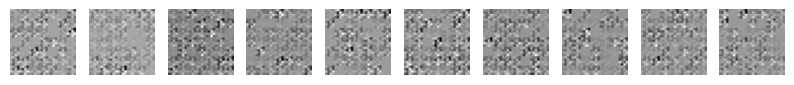

disc_loss 1.36121321 gen_loss 1.21046448 ssim 0.986518323
disc_loss 1.4202888 gen_loss 1.20671356 ssim 0.984361649
disc_loss 1.32858169 gen_loss 1.1779151 ssim 0.980704427
disc_loss 1.3915534 gen_loss 1.22672129 ssim 0.985689938
disc_loss 1.3972168 gen_loss 1.2162962 ssim 0.984250546
Epoch 10/20000
1/1 [==============================] - 0s 35ms/step


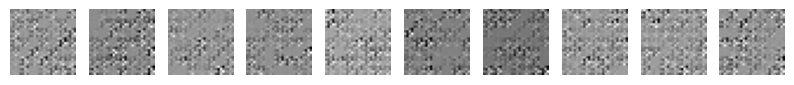

disc_loss 1.37917829 gen_loss 1.23538232 ssim 0.981062412
disc_loss 1.34261823 gen_loss 1.1984117 ssim 0.976734817
disc_loss 1.36760211 gen_loss 1.20147848 ssim 0.980077863
disc_loss 1.34410548 gen_loss 1.25816572 ssim 0.97739917
disc_loss 1.36399376 gen_loss 1.23288131 ssim 0.977805078
Epoch 15/20000
1/1 [==============================] - 0s 45ms/step


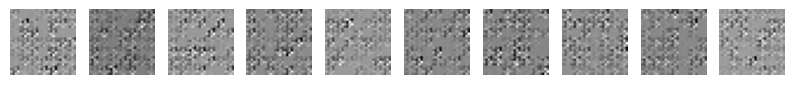

disc_loss 1.33634853 gen_loss 1.23763156 ssim 0.977022827
disc_loss 1.36520624 gen_loss 1.25342131 ssim 0.978865564
disc_loss 1.3743217 gen_loss 1.25715172 ssim 0.980792463
disc_loss 1.3458463 gen_loss 1.27614391 ssim 0.973378658
disc_loss 1.33338857 gen_loss 1.2254324 ssim 0.974496484
Epoch 20/20000
1/1 [==============================] - 0s 29ms/step


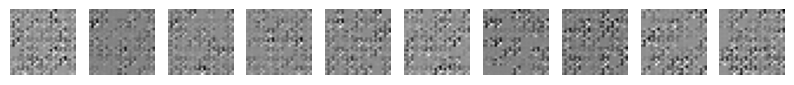

disc_loss 1.32360196 gen_loss 1.24706697 ssim 0.974405706
disc_loss 1.30716515 gen_loss 1.2398802 ssim 0.975157201
disc_loss 1.36249423 gen_loss 1.24997401 ssim 0.972875595
disc_loss 1.37994289 gen_loss 1.28254449 ssim 0.97110188
disc_loss 1.34037423 gen_loss 1.24620342 ssim 0.972125471
Epoch 25/20000
1/1 [==============================] - 0s 38ms/step


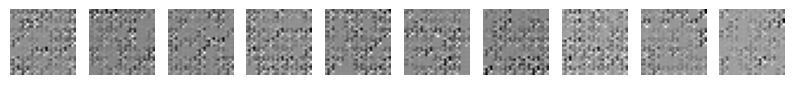

disc_loss 1.32766199 gen_loss 1.27236724 ssim 0.967409909
disc_loss 1.31230056 gen_loss 1.25708854 ssim 0.973262727
disc_loss 1.33403409 gen_loss 1.34508443 ssim 0.970211506
disc_loss 1.29978609 gen_loss 1.28386128 ssim 0.969463944
disc_loss 1.29233217 gen_loss 1.32082713 ssim 0.963694513
Epoch 30/20000
1/1 [==============================] - 0s 42ms/step


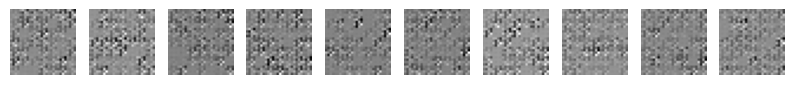

disc_loss 1.32217395 gen_loss 1.34487236 ssim 0.966728151
disc_loss 1.26893651 gen_loss 1.33361578 ssim 0.964184
disc_loss 1.28067982 gen_loss 1.29538798 ssim 0.965730488
disc_loss 1.27772975 gen_loss 1.33497441 ssim 0.95710963
disc_loss 1.2568289 gen_loss 1.33407462 ssim 0.95333147
Epoch 35/20000
1/1 [==============================] - 0s 28ms/step


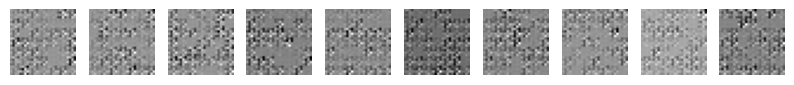

disc_loss 1.26732671 gen_loss 1.33238435 ssim 0.957292557
disc_loss 1.28646731 gen_loss 1.38174832 ssim 0.954729676
disc_loss 1.29034472 gen_loss 1.35416758 ssim 0.955085933
disc_loss 1.31699014 gen_loss 1.35485029 ssim 0.949078679
disc_loss 1.21170914 gen_loss 1.43447983 ssim 0.949143827
Epoch 40/20000
1/1 [==============================] - 0s 35ms/step


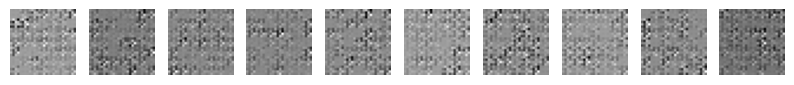

disc_loss 1.21763742 gen_loss 1.46084404 ssim 0.955259621
disc_loss 1.20252264 gen_loss 1.46112657 ssim 0.941462159
disc_loss 1.23336077 gen_loss 1.50453699 ssim 0.947312355
disc_loss 1.26893508 gen_loss 1.47811723 ssim 0.947590292
disc_loss 1.16999912 gen_loss 1.57109427 ssim 0.949904263
Epoch 45/20000
1/1 [==============================] - 0s 30ms/step


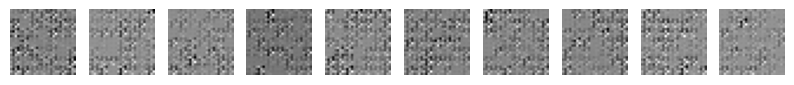

disc_loss 1.18079567 gen_loss 1.60857284 ssim 0.945528209
disc_loss 1.22436976 gen_loss 1.52727473 ssim 0.943095386
disc_loss 1.15047646 gen_loss 1.60997367 ssim 0.944506109
disc_loss 1.14041829 gen_loss 1.61248386 ssim 0.937631905
disc_loss 1.10745645 gen_loss 1.64394903 ssim 0.929965198
Epoch 50/20000
1/1 [==============================] - 0s 30ms/step


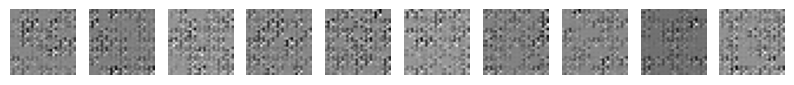

disc_loss 1.12397277 gen_loss 1.60235155 ssim 0.941495121
disc_loss 1.08687878 gen_loss 1.67692947 ssim 0.928726375
disc_loss 1.04720426 gen_loss 1.60436285 ssim 0.920153558
disc_loss 1.06151044 gen_loss 1.64881659 ssim 0.921007097
disc_loss 1.12304163 gen_loss 1.76930928 ssim 0.926988125
Epoch 55/20000
1/1 [==============================] - 0s 32ms/step


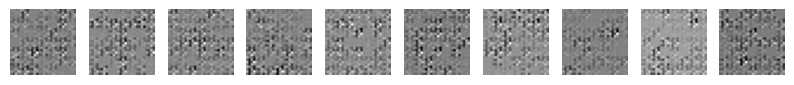

disc_loss 1.03084075 gen_loss 1.82074845 ssim 0.910754144
disc_loss 0.984095752 gen_loss 1.76950109 ssim 0.921634853
disc_loss 0.991835594 gen_loss 1.90096211 ssim 0.908381104
disc_loss 1.03533852 gen_loss 1.99623179 ssim 0.926717937
disc_loss 1.00736022 gen_loss 1.99788737 ssim 0.903176
Epoch 60/20000
1/1 [==============================] - 0s 33ms/step


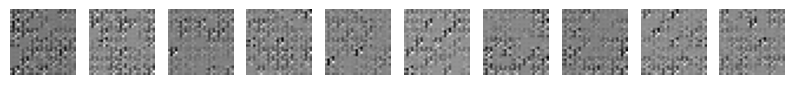

disc_loss 0.921200514 gen_loss 1.94372177 ssim 0.916232526
disc_loss 1.07719421 gen_loss 2.12285948 ssim 0.911883
disc_loss 0.991171241 gen_loss 2.05327392 ssim 0.911533058
disc_loss 0.966188 gen_loss 2.07837892 ssim 0.900956273
disc_loss 0.970959306 gen_loss 2.13883853 ssim 0.903902829
Epoch 65/20000
1/1 [==============================] - 0s 36ms/step


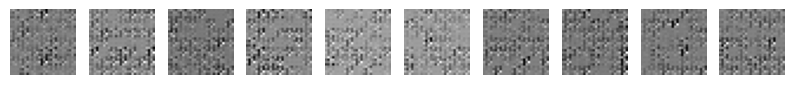

disc_loss 0.878828585 gen_loss 2.07876039 ssim 0.892222703
disc_loss 0.848711431 gen_loss 2.09565496 ssim 0.896059692
disc_loss 0.83003509 gen_loss 2.2070961 ssim 0.887335479
disc_loss 0.83656621 gen_loss 2.23463178 ssim 0.87946713
disc_loss 0.833256662 gen_loss 2.42782283 ssim 0.883657873
Epoch 70/20000
1/1 [==============================] - 0s 28ms/step


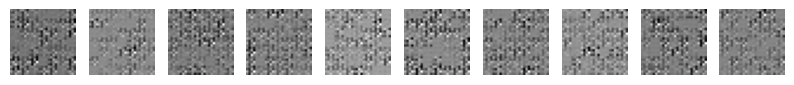

disc_loss 0.834917903 gen_loss 2.41694283 ssim 0.885080516
disc_loss 0.86420238 gen_loss 2.58146715 ssim 0.873292744
disc_loss 0.75936985 gen_loss 2.57296777 ssim 0.884743214
disc_loss 0.786597252 gen_loss 2.5973978 ssim 0.885026932
disc_loss 0.71978128 gen_loss 2.60054088 ssim 0.879953563


KeyboardInterrupt: ignored

In [23]:
@tf.function
def train_step(images, labels,num_unrolling_steps):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 28, 28, 1])

    for _ in range(num_unrolling_steps):
        with tf.GradientTape() as disc_tape:
            generated_images = generator([noise, labels], training=True)

            real_output = discriminator([images, labels], training=True)
            fake_output = discriminator([generated_images, labels], training=True)

            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator([noise, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        ssim = compute_ssim(generated_images[:5])
        gen_loss = generator_loss(fake_output)+(ssim*.5)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss,'ssim',ssim)
def train(generator, discriminator, gan, epochs, batch_size,num_unrolling_steps):
    for epoch in range(epochs):
        for batch in range(len(x_train2) // batch_size):
            images = x_train2[batch * batch_size: (batch+1) * batch_size]
            labels = y_train2[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels,num_unrolling_steps)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            # Generate and save sample images
            noise = tf.random.normal([10, 28, 28, 1])
            sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
            generated_images = generator.predict([noise, sampled_labels])
            generated_images = generated_images#(generated_images * 0.5) + 0.5  # Rescale images from [-1, 1] to [0, 1]
            fig, axs = plt.subplots(1, 10, figsize=(10, 10))
            for i in range(10):
                axs[i].imshow(generated_images[i], cmap="gray")
                axs[i].axis("off")
            plt.show()

# Train the GAN
EPOCHS = 20000
BATCH_SIZE = 64
num_unrolling_steps = 2  # Set the desired number of unrolling steps
train(generator, discriminator, gan, EPOCHS, BATCH_SIZE,num_unrolling_steps=num_unrolling_steps)

In [ ]:
@tf.function
def train_step(images, labels,num_unrolling_steps):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 28, 28, 1])


    generated_images = generator([noise, labels], training=True)
    real_output = discriminator([images, labels], training=True)
    fake_output = discriminator([generated_images, labels], training=True)
    disc_loss = discriminator_loss(real_output, fake_output)
    gen_loss = generator_loss(fake_output)

    if disc_loss>gen_loss:
      for _ in range(num_unrolling_steps):
          with tf.GradientTape() as disc_tape:
              generated_images = generator([noise, labels], training=True)

              real_output = discriminator([images, labels], training=True)
              fake_output = discriminator([generated_images, labels], training=True)

              disc_loss = discriminator_loss(real_output, fake_output)

          gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

      with tf.GradientTape() as gen_tape:
          generated_images = generator([noise, labels], training=True)
          fake_output = discriminator([generated_images, labels], training=True)
          ssim = compute_ssim(generated_images[:5])
          gen_loss += ssim
          gen_loss = generator_loss(fake_output)
    else:
      for _ in range(num_unrolling_steps):
          with tf.GradientTape() as gen_tape:
              generated_images = generator([noise, labels], training=True)
              fake_output = discriminator([generated_images, labels], training=True)
              gen_loss = generator_loss(fake_output)
              ssim = compute_ssim(generated_images[:5])
              gen_loss += ssim

          gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
          generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      with tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss,'ssim',ssim)
def train(generator, discriminator, gan, epochs, batch_size,num_unrolling_steps):
    for epoch in range(epochs):
        for batch in range(len(x_train2) // batch_size):
            images = x_train2[batch * batch_size: (batch+1) * batch_size]
            labels = y_train2[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels,num_unrolling_steps)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            # Generate and save sample images
            noise = tf.random.normal([10, 28, 28, 1])
            sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
            generated_images = generator.predict([noise, sampled_labels])
            generated_images = generated_images#(generated_images * 0.5) + 0.5  # Rescale images from [-1, 1] to [0, 1]
            fig, axs = plt.subplots(1, 10, figsize=(10, 10))
            for i in range(10):
                axs[i].imshow(generated_images[i], cmap="gray")
                axs[i].axis("off")
            plt.show()

# Train the GAN
EPOCHS = 20000
BATCH_SIZE = 64
num_unrolling_steps = 5  # Set the desired number of unrolling steps
train(generator, discriminator, gan, EPOCHS, BATCH_SIZE,num_unrolling_steps=num_unrolling_steps)